In [ ]:
import findspark
findspark.init('c:\spark')

In [3]:
import pandas as pd
from pyspark.sql import SQLContext
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, ArrayType
from pyspark.sql import SparkSession
import multiprocessing 

In [4]:
sc =SparkContext()
sqlContext = SQLContext(sc)

In [5]:
df = sqlContext.read.csv('insurance.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [6]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,1338,39.20702541106129,14.049960379216147,18,64
sex,1338,None,None,female,male
bmi,1338,30.663396860986538,6.098186911679012,15.96,53.13
children,1338,1.0949177877429,1.205492739781914,0,5
smoker,1338,None,None,no,yes
region,1338,None,None,northeast,southwest
charges,1338,13270.422265141257,12110.011236693992,1121.8739,63770.42801


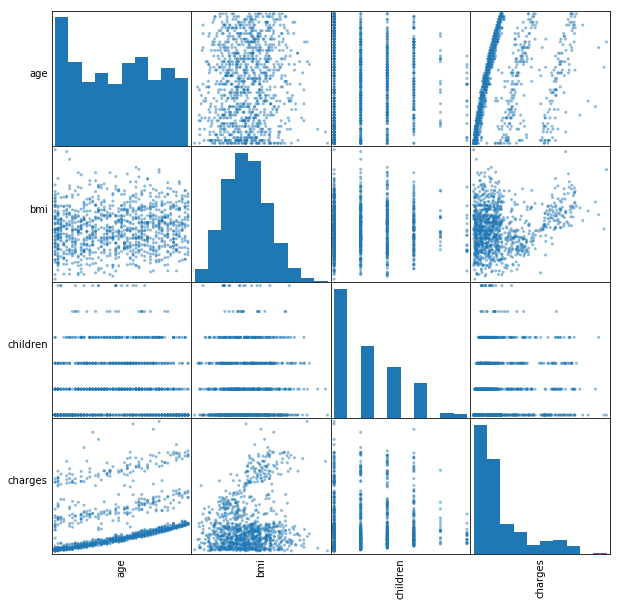

In [8]:
import pandas as pd
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(()) 

In [10]:
df_pd=pd.read_csv('insurance.csv',sep=",",encoding = 'unicode_escape')

In [11]:
df_pd.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [28]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
categoricalColumns = ['sex','smoker','region']
stringIndexer = [StringIndexer(inputCol=column, outputCol=column + "Index") for column in categoricalColumns]
pipeline = Pipeline(stages=stringIndexer)
df_indexed = pipeline.fit(df).transform(df)
df_indexed.take(1)

[Row(age=19, sex='female', bmi=27.9, children=0, smoker='yes', region='southwest', charges=16884.924, sexIndex=1.0, smokerIndex=1.0, regionIndex=1.0)]

In [32]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['age','sexIndex','bmi','children','smokerIndex','regionIndex'], outputCol = 'features')

In [34]:
v_df = vectorAssembler.transform(df_indexed)

In [36]:
v_df = v_df.select(['features', 'charges'])

In [38]:
v_df.show(3)

+--------------------+---------+
|            features|  charges|
+--------------------+---------+
|[19.0,1.0,27.9,0....|16884.924|
|[18.0,0.0,33.77,1...|1725.5523|
|[28.0,0.0,33.0,3....| 4449.462|
+--------------------+---------+
only showing top 3 rows



In [39]:
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [40]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='charges', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [246.24896952828584,442.53371327004953,332.79358670079745,514.7259907237826,24481.888783433635,437.7820352272297]
Intercept: -12656.886377177783


In [41]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 6261.216311
r2: 0.744012


In [42]:
train_df.describe().show()

+-------+------------------+
|summary|           charges|
+-------+------------------+
|  count|               948|
|   mean| 13557.74398024155|
| stddev|12381.633749321538|
|    min|         1121.8739|
|    max|       63770.42801|
+-------+------------------+



In [43]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","charges","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="charges",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+---------+--------------------+
|        prediction|  charges|            features|
+------------------+---------+--------------------+
| 1805.993777493397|1131.5066|(6,[0,2],[18.0,30...|
| 3233.678264439819|1137.4697|(6,[0,2],[18.0,34...|
| 4185.467922404099|1141.4451|(6,[0,2],[18.0,37...|
| 9456.918335744733|1163.4627|(6,[0,2],[18.0,53...|
|238.48113024172926|1515.3449|(6,[0,2],[21.0,23...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.762467


In [44]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5552.86


In [45]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.4138164386810396, 0.19923258601966023, 0.14621679170887023, 0.12822519314573877, 0.12802720416635777, 0.12802199335455475, 0.12802185663231958, 0.12802185157442567, 0.12802185123327078, 0.12802185123271304]
+-------------------+
|          residuals|
+-------------------+
| 1622.1396783431296|
| -1731.664619068938|
|-1841.0278026802027|
|-1986.8453808285544|
|  -4319.92663120217|
|  -4939.65133833266|
|-1968.5745581255112|
| 13748.898667625044|
| -2806.028418395553|
|-3243.4811528406044|
|-27.771219493907665|
|-13.322005410932434|
| -5116.937240603211|
|-1924.2297017936046|
| -3200.133510591675|
| -3210.513871499895|
|  804.3683471256436|
| -2367.163977600987|
|-2695.2535284347737|
| -4214.713279446572|
+-------------------+
only showing top 20 rows



In [46]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","charges","features").show()

+------------------+-----------+--------------------+
|        prediction|    charges|            features|
+------------------+-----------+--------------------+
| 1805.993777493397|  1131.5066|(6,[0,2],[18.0,30...|
| 3233.678264439819|  1137.4697|(6,[0,2],[18.0,34...|
| 4185.467922404099|  1141.4451|(6,[0,2],[18.0,37...|
| 9456.918335744733|  1163.4627|(6,[0,2],[18.0,53...|
|238.48113024172926|  1515.3449|(6,[0,2],[21.0,23...|
| 3999.030375330436|  1674.6323|(6,[0,2],[22.0,33...|
|3842.5991049507575|  1824.2854|(6,[0,2],[23.0,32...|
|2065.4447827078875|  2137.6536|(6,[0,2],[25.0,25...|
| 5958.818908392044|  5966.8874|(6,[0,2],[42.0,24...|
| 8075.239842766685|   8442.667|(6,[0,2],[50.0,25...|
|13632.746463627565| 11363.2832|(6,[0,2],[58.0,36...|
| 24354.28305895104| 12829.4551|[18.0,0.0,17.29,2...|
|234.01948647917015|  1702.4553|[18.0,0.0,21.47,0...|
|24747.523660649385|13747.87235|[18.0,0.0,21.565,...|
| 25948.90850863926|15518.18025|[18.0,0.0,25.175,...|
| 1561.865897415355|  1708.0